In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.animation import FuncAnimation, PillowWriter
import itertools
from itertools import repeat
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"
rcParams["xtick.top"] = True
rcParams["ytick.right"] = True
rcParams["font.size"] = 14

In [3]:
def get_data(logs_dir):
    freqs = []
    profs = []
    n_profs = []
    # prof_index = pd.read_table(f"{logs_dir}/profiles.index", skiprows=1, sep='\s+')
    prof_index = np.loadtxt(f"{logs_dir}/profiles.index", skiprows=1, dtype=int)

    for f in sorted(glob.glob(f"{logs_dir}/profile*.data.GYRE"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1])):
        profs.append(pd.read_table(f, skiprows=5, sep='\s+'))

    for f in sorted(glob.glob(f"{logs_dir}/profile*-freqs.dat"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1].split('-')[0])):
        freqs.append(pd.read_table(f, skiprows=5, sep='\s+'))
        n_profs.append(int(f.split('profile')[-1].split('-')[0]))
    hist = pd.read_table(glob.glob(f"{logs_dir}/history.data")[0], skiprows=5, sep='\s+')

    return hist, freqs, profs, n_profs, prof_index

# hist, freqs, profs, n_profs, prof_index = get_data("tests_here/test_M1.5_Z0.01/LOGS")
# n_profs

In [4]:
logs_dirs = sorted(glob.glob("../test/m1.7_z0.015_v0_net*/LOGS"))
nets = [logs_dir.split('/')[-2].split('net')[-1] for logs_dir in logs_dirs]
run_times = []
for i, logs_dir in enumerate(logs_dirs):
    logfn = "".join(logs_dir.split("LOGS")) + "run.log"
    with open(logfn, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "Total" in line:
                run_time = float(line.split(" ")[-2])
                run_times.append(run_time)
# logs_dirs
print(run_times)
print(nets)
net_labels = [net.replace("_", "\\_") for net in nets]
net_labels

[128.95581531524658, 174.75741481781006, 282.2259466648102, 253.6868007183075, 158.2733702659607]
['basic', 'hot_cno', 'pp_and_cno_extras', 'pp_and_hot_cno', 'pp_extras']


['basic',
 'hot\\_cno',
 'pp\\_and\\_cno\\_extras',
 'pp\\_and\\_hot\\_cno',
 'pp\\_extras']

In [101]:
M_sample = [1.7]
Z_sample = [0.015]
V_sample = [0]

combinations = list(itertools.product(M_sample, Z_sample, V_sample, nets))

data_dict = {}

k = 0
for m, z, v, net in combinations:
    print(m, z, v, net)
    key = f"M={m}_Z={z}_V={v}_net={net}"
    hist, freqs, profs, n_profs, prof_index = get_data(logs_dirs[k])
    data_dict[key] = {}
    data_dict[key]['age'] = hist['star_age']/1e6
    data_dict[key]['log_Lcno'] = hist['cno'].values
    data_dict[key]['log_Lpp'] = hist['pp'].values
    data_dict[key]['log_Lnuc'] = hist['log_Lnuc'].values
    data_dict[key]['log_cntr_Rho'] = hist['log_cntr_Rho'].values
    data_dict[key]['log_Teff'] = hist['log_Teff'].values
    data_dict[key]['log_L'] = hist['log_L'].values
    data_dict[key]['log_LH'] = hist['log_LH'].values
    data_dict[key]['log_LHe'] = hist['log_LHe'].values
    data_dict[key]['log_LZ'] = hist['log_LZ'].values
    data_dict[key]['center_h1'] = hist['center_h1'].values
    data_dict[key]['center_he4'] = hist['center_he4'].values
    data_dict[key]['average_h1'] = hist['average_h1'].values
    data_dict[key]['average_he4'] = hist['average_he4'].values
    data_dict[key]['total_mass_h1'] = hist['total_mass_h1'].values
    data_dict[key]['total_mass_he4'] = hist['total_mass_he4'].values
    k += 1

1.7 0.015 0 basic
1.7 0.015 0 hot_cno
1.7 0.015 0 pp_and_cno_extras
1.7 0.015 0 pp_and_hot_cno
1.7 0.015 0 pp_extras


In [102]:
def interp(x, y, age):
    f_linear = interp1d(x, y, fill_value=0)
    return f_linear(age)

key_ref = f"M=1.7_Z=0.015_V=0_net={nets[2]}"
age = np.arange(3, data_dict[key_ref]['age'].values[-1], 0.1)

data_dict_interp = {}
for key in data_dict.keys():
    data_dict_interp[key] = {}
    for k in data_dict[key].keys():
        data_dict_interp[key][k] = interp(data_dict[key]['age'], data_dict[key][k], age)

data_dict = data_dict_interp

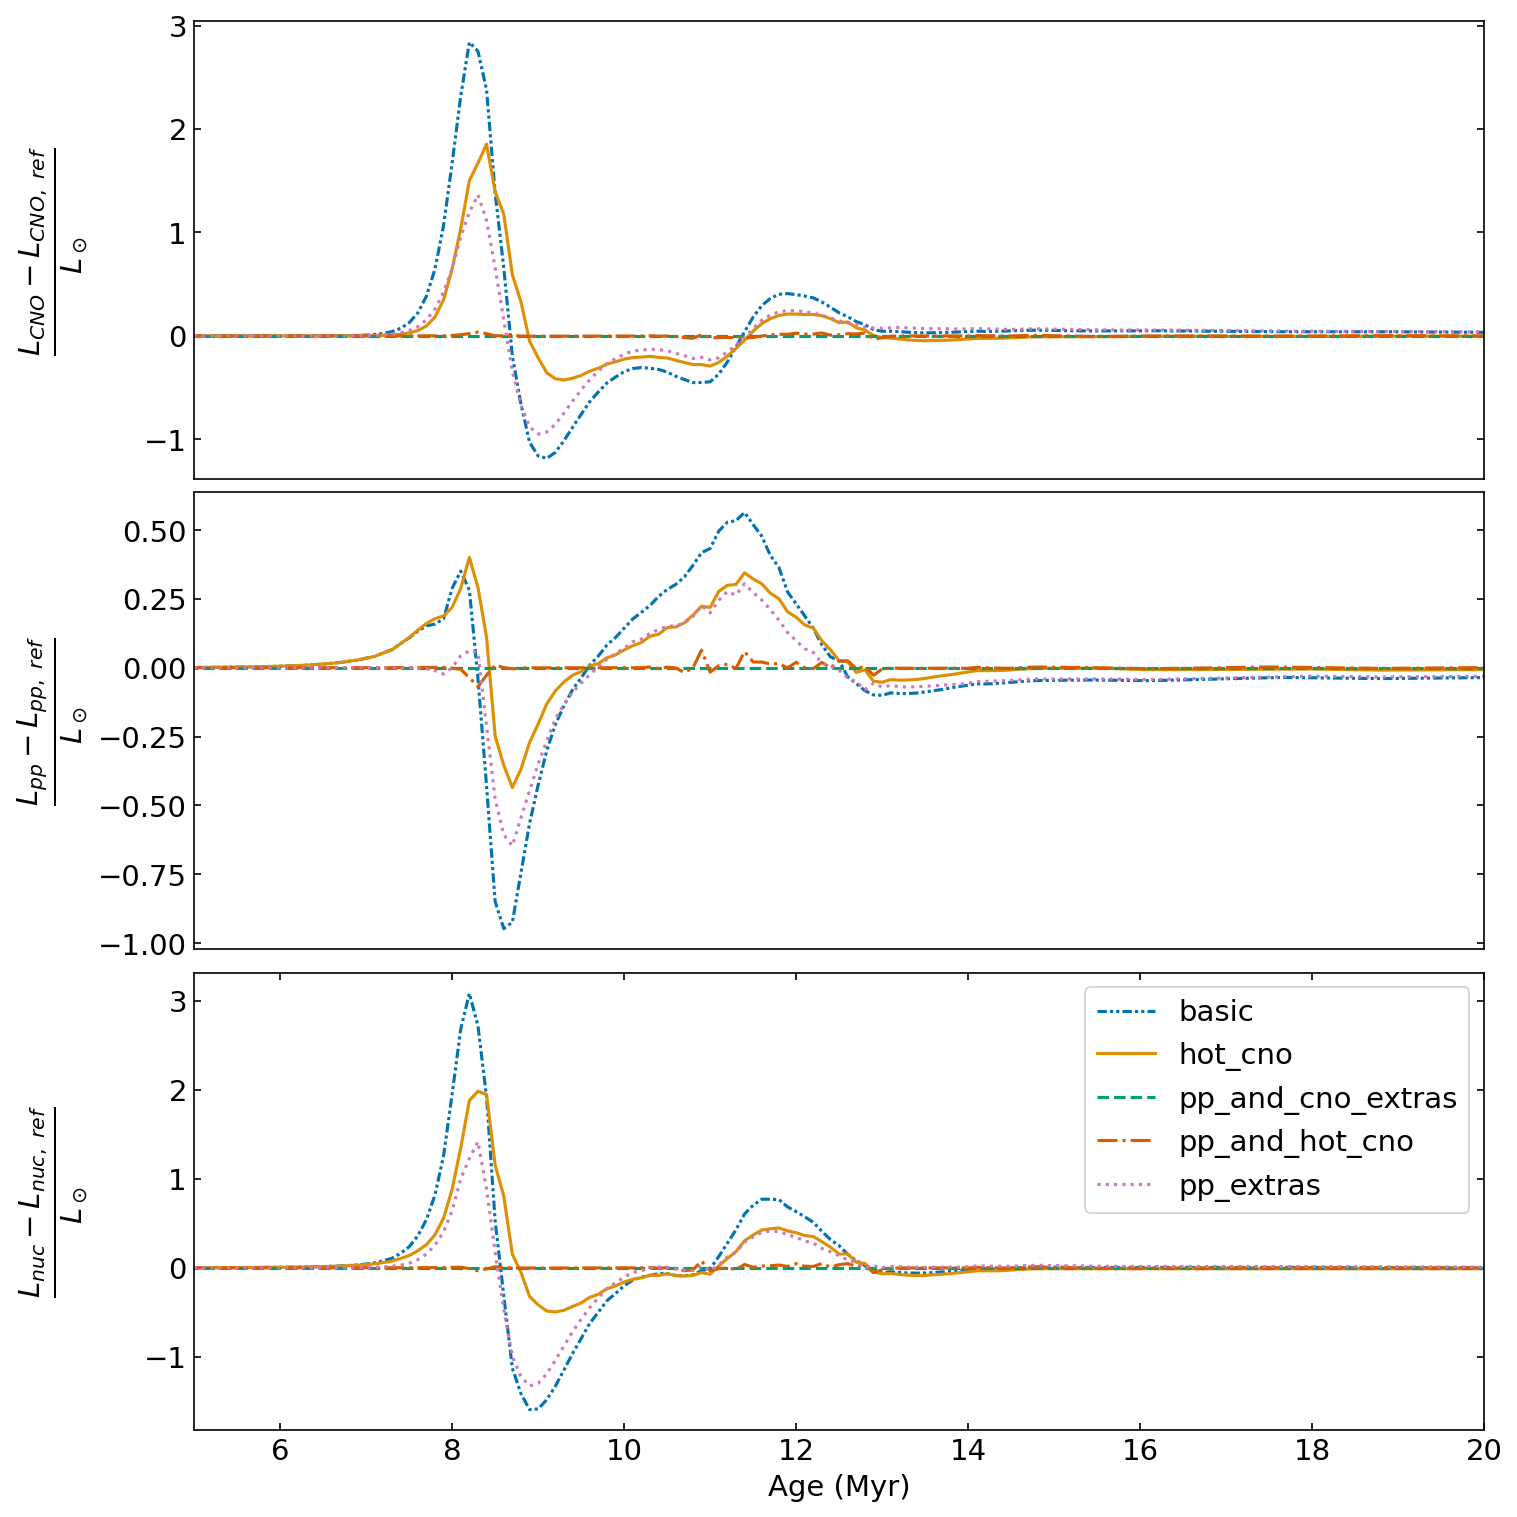

In [103]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
linestyle_tuple = [(0, (3, 1, 1, 1, 1, 1)), 'solid', '--', '-.', ':']
palette = sns.color_palette("colorblind", len(nets))
key_ref = f"M=1.7_Z=0.015_V=0_net={nets[2]}"

ax1 = plt.subplot(3, 1, 1)
for i, net in enumerate(nets):
    key = f"M=1.7_Z=0.015_V=0_net={net}"
    y = (10**data_dict[key]['log_Lcno'] - 10**data_dict[key_ref]['log_Lcno']) 
    plt.plot(data_dict[key]['age'], y, color=palette[i],
             linestyle=linestyle_tuple[i], label=net)
plt.xlim(5, 20)
plt.xticks([])
plt.ylabel(r"$\frac{L_{CNO} - L_{CNO,\ ref}}{L_\odot}$", fontsize=20)

ax2 = plt.subplot(3, 1, 2)
for i, net in enumerate(nets):
    key = f"M=1.7_Z=0.015_V=0_net={net}"
    y = (10**data_dict[key]['log_Lpp'] - 10**data_dict[key_ref]['log_Lpp']) 
    plt.plot(data_dict[key]['age'], y, color=palette[i],
             linestyle=linestyle_tuple[i], label=net)
plt.xlim(5, 20)
# plt.ylim(0, 8)
plt.xticks([])
plt.ylabel(r"$\frac{L_{pp} - L_{pp,\ ref}}{L_\odot}$", fontsize=20)

ax3 = plt.subplot(3, 1, 3)
for i, net in enumerate(nets):
    key = f"M=1.7_Z=0.015_V=0_net={net}"
    y = data_dict[key]['log_Lnuc']
    y = (10**data_dict[key]['log_Lnuc'] - 10**data_dict[key_ref]['log_Lnuc']) 
    plt.plot(data_dict[key]['age'], y, color=palette[i],
             linestyle=linestyle_tuple[i], label=net)
plt.xlim(5, 20)
# plt.ylim(0, 12)
plt.ylabel(r"$\frac{L_{nuc} - L_{nuc,\ ref}}{L_\odot}$", fontsize=20)

plt.xlabel("Age (Myr)")
plt.legend()
fig.align_ylabels([ax1, ax2, ax3])
# plt.savefig("../figures/net_comp_1.7.png", dpi=300)
plt.show()

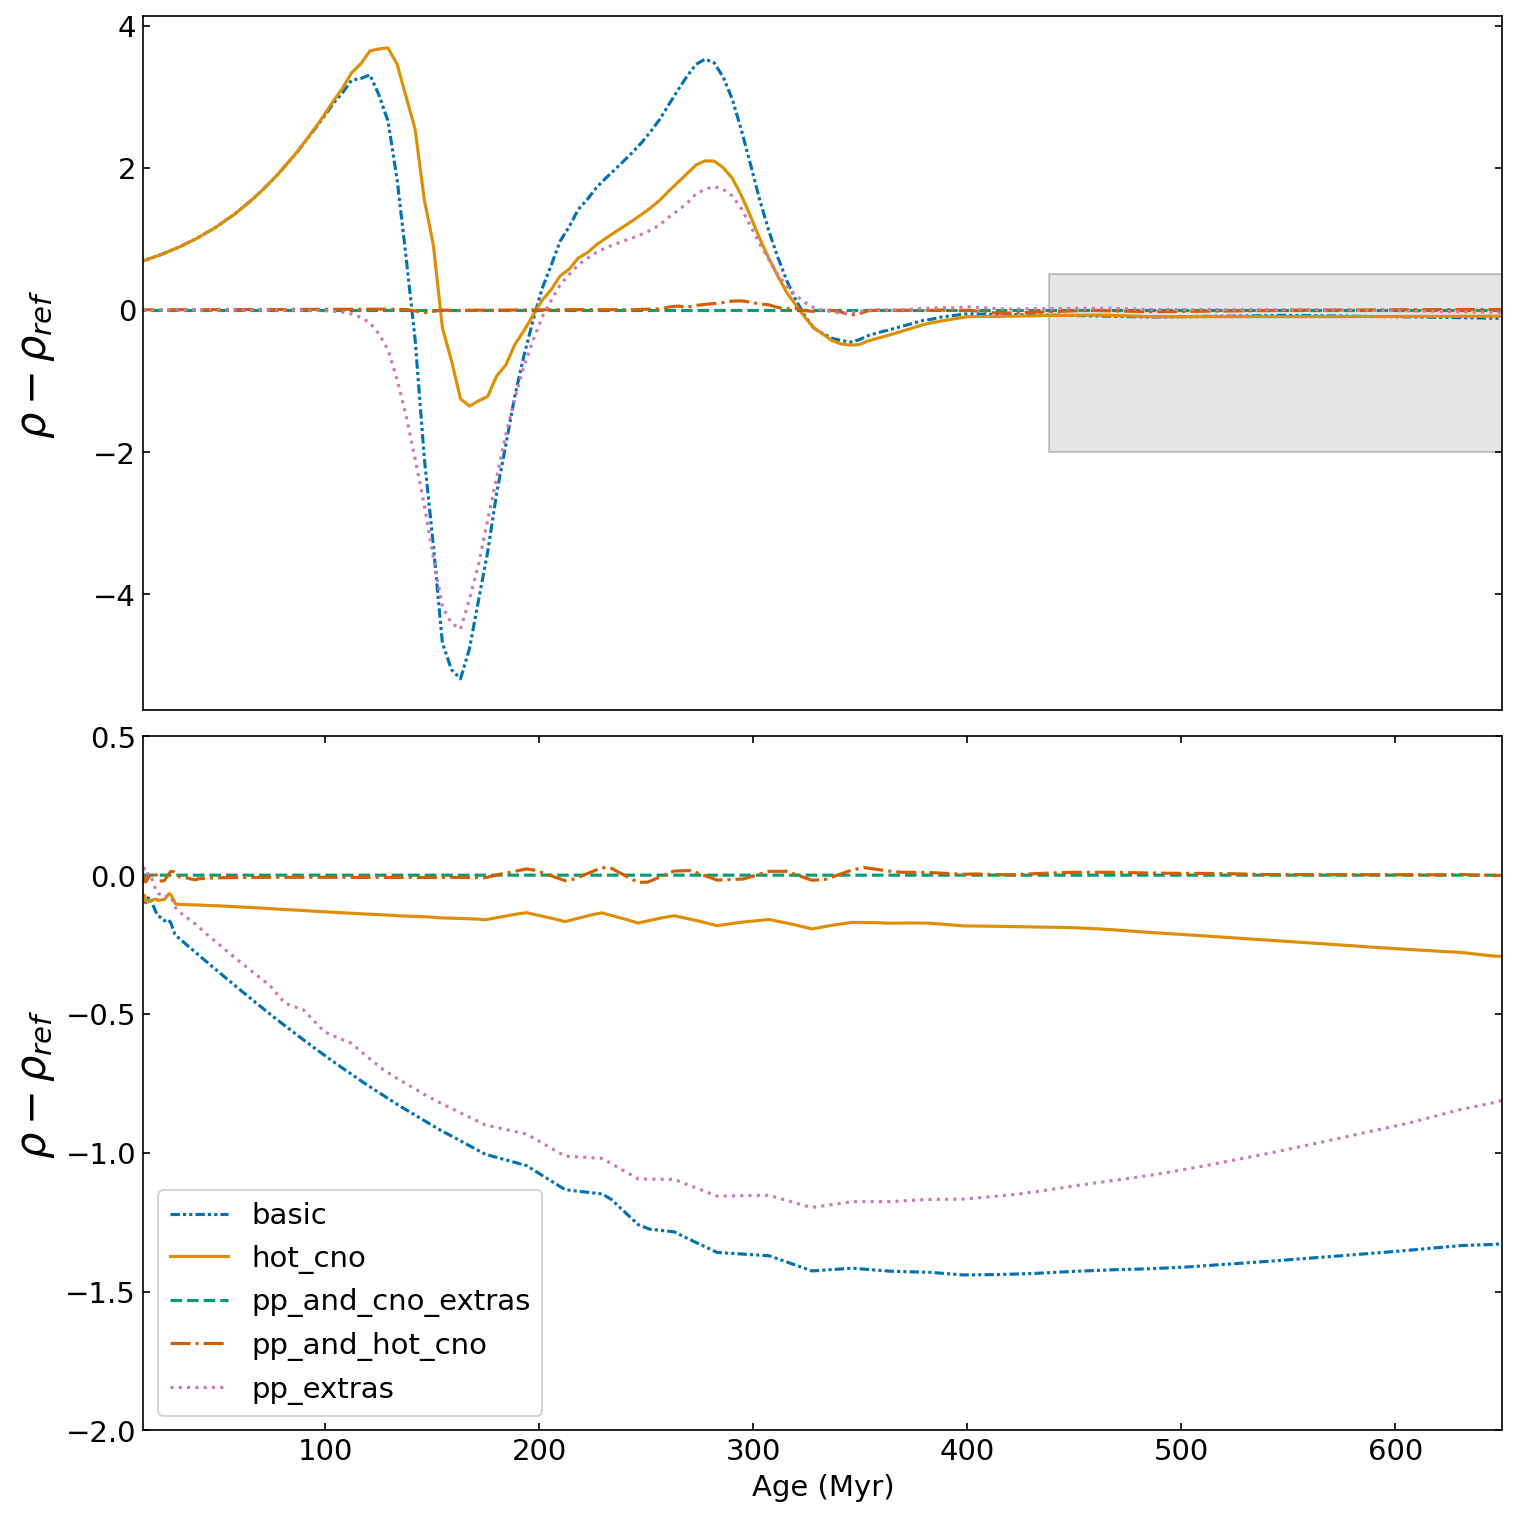

In [112]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
linestyle_tuple = [(0, (3, 1, 1, 1, 1, 1)), 'solid', '--', '-.', ':']
palette = sns.color_palette("colorblind", len(nets))
key_ref = f"M=1.7_Z=0.015_V=0_net={nets[2]}"

ax1 = plt.subplot(2, 1, 1)
for i, net in enumerate(nets):
    key = f"M=1.7_Z=0.015_V=0_net={net}"
    y = (10**data_dict[key]['log_cntr_Rho'] - 10**data_dict[key_ref]['log_cntr_Rho']) 
    plt.plot(data_dict[key]['age'], y, color=palette[i],
             linestyle=linestyle_tuple[i], label=net)
plt.xlim(5, 20)
plt.xticks([])
plt.ylabel(r"$\rho - \rho_{ref}$", fontsize=20)
rect = mpl.patches.Rectangle((15, -2), 20, 2.5, linewidth=1, edgecolor='k', facecolor='grey', alpha=0.2)
ax1.add_patch(rect)

ax2 = plt.subplot(2, 1, 2)
for i, net in enumerate(nets):
    key = f"M=1.7_Z=0.015_V=0_net={net}"
    y = (10**data_dict[key]['log_cntr_Rho'] - 10**data_dict[key_ref]['log_cntr_Rho']) 
    plt.plot(data_dict[key]['age'], y, color=palette[i],
             linestyle=linestyle_tuple[i], label=net)
plt.xlim(15, 650)
plt.ylim(-2, 0.5)
plt.ylabel(r"$\rho - \rho_{ref}$", fontsize=20)



fig.align_ylabels([ax1, ax2])

plt.xlabel("Age (Myr)")
plt.legend()
# plt.savefig("../figures/net_comp_1.7.png", dpi=300)
plt.show()